In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

In [3]:
# Hopkins
#Calculating the Hopkins statistic
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan
 
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), \
                                    2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1]) 

    H = np.sum(ujd) / (np.sum(ujd) + np.sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

#### Here we are trying to 
- Categorise the countries using some socio-economic and health factors that determine the overall development of the country.
- Make suggestions on the countries which the need to focus on the most.

## Loading the Data and Initial Anlalysis

In [4]:
df_countries = pd.read_csv('Country-data.csv')
features = list (df_countries.columns)[1:]
df_countries.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [5]:
df_countries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
country       167 non-null object
child_mort    167 non-null float64
exports       167 non-null float64
health        167 non-null float64
imports       167 non-null float64
income        167 non-null int64
inflation     167 non-null float64
life_expec    167 non-null float64
total_fer     167 non-null float64
gdpp          167 non-null int64
dtypes: float64(7), int64(2), object(1)
memory usage: 13.1+ KB


Nice that there are no null values!

In [6]:
df_countries.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,41.108976,6.815689,46.890215,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,27.412010,2.746837,24.209589,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,0.109000,1.810000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,23.800000,4.920000,30.200000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,35.000000,6.320000,43.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,51.350000,8.600000,58.750000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,200.000000,17.900000,174.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


In [7]:
# This map will be useful in creating Axis titles in graphs.
feature_map = {'child_mort': 'Child Mortality', 'exports':'Exports % of GDP', 'health':'Health Expense % of GDP',
              'imports': 'Import % of GDP', 'income':'Income', 'inflation':'Inflation',
              'life_expec': 'Life Expectancy', 'total_fer': 'Total Fertility', 'gdpp':'GDP per Capita'}

## Checking the correlations

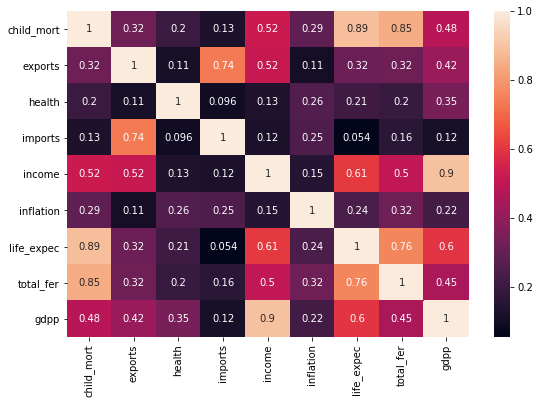

In [8]:
plt.figure(figsize = (9, 6))     # Size of the figure
sns.heatmap(abs(df_countries.corr()),annot = True) # Checking the absolute values only

#### There is a lot of correlations. Let us try to remove this and proceed. But, let's see the outliers for now

## Checking for the outliers

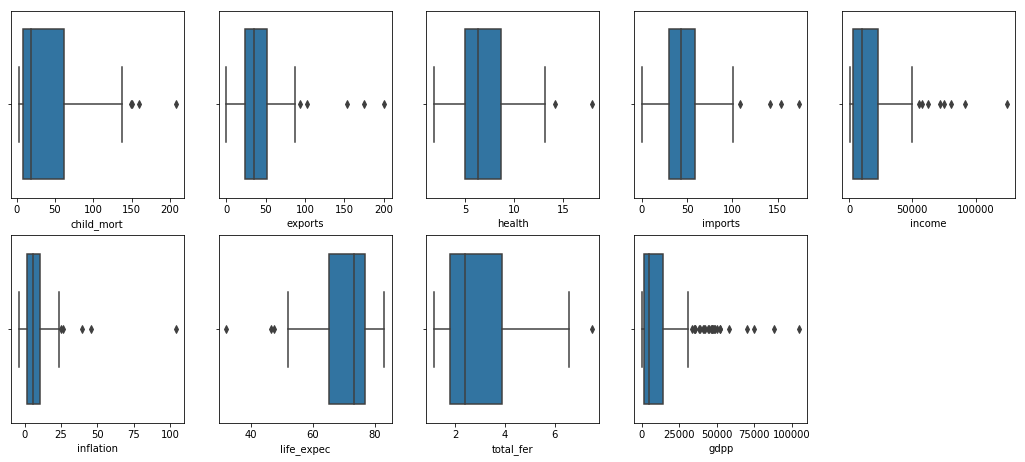

In [9]:
plt.figure(figsize = (18,20))
for i in enumerate(features):
    plt.subplot(5,5, i[0]+1)
    sns.boxplot(x = i[1], data = df_countries)
plt.show()

#### Let us try to see the outliers in a scatter plot in order to understand how much will they influence the clustering

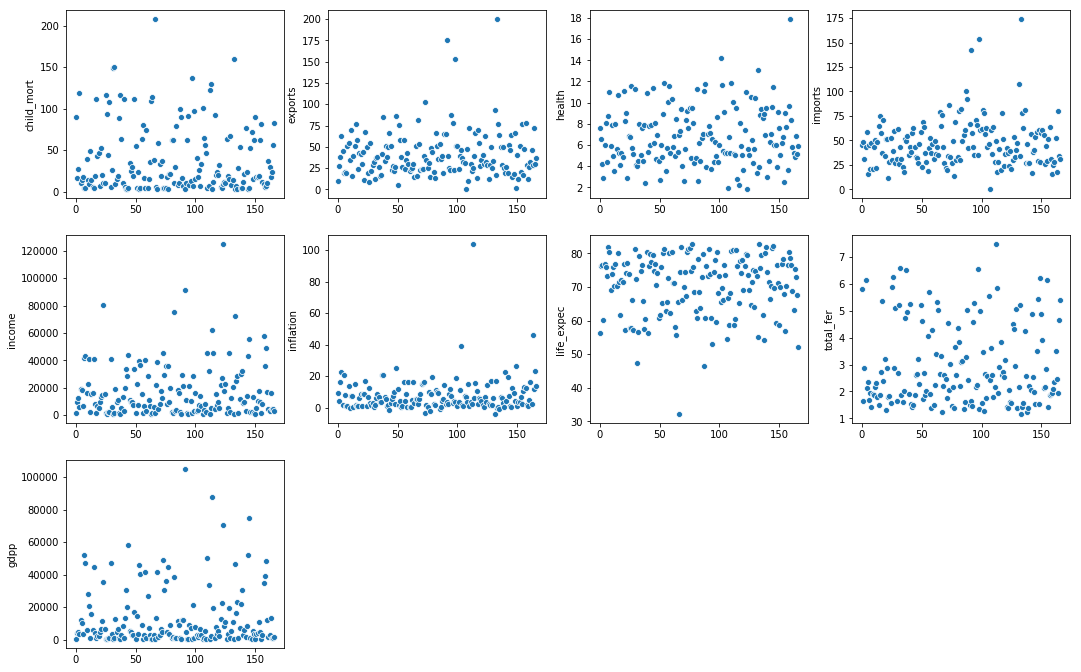

In [10]:
plt.figure(figsize = (18,20))
for i in enumerate(features):
    plt.subplot(5,4, i[0]+1)
    sns.scatterplot(x=df_countries.index, y = i[1], data = df_countries)

- There are many kinds of features. Here we are trying to help out the **poor countries**. Hence, although there might be outliers in the features which suggest how bad a country is doing, it will not be wise to discard those outliers. These countries might as well need more help!

- It may be okay to discard the countries which are doing too well in terms of health expenditure, imports, exports, gdpp, etc. However it will not be wise to drop the countries which are doing too worse. Hence, we will only drop the countries which are doing very well. Although we will list the countries which are doing too badly.

### Few observations from the scatter plots
   1. In a country, the inflation is too huge. It needs to be removed
   2. Life expectancy is very low in a country. It needs to be looked at and then decided if it has to be removed or not.
   3. One of the countries has a very high per capita income. It can be removed
   4. Although there are high outliers in child mortality, these countries might need help so must not be dropped.

In [11]:
# Removing the countries where exports and imports are more than or equal to the GDP
df_countries_capped = df_countries.copy()
printmd ('These countries will be removed for imports/exports anomaly: **%s, %s**' % (\
         (', '.join(list(df_countries_capped.loc[df_countries_capped.exports >= 100, 'country'].values))), \
        (', '.join(list(df_countries_capped.loc[df_countries_capped.imports >= 100, 'country'].values)))) )

These countries will be removed for imports/exports anomaly: **Ireland, Luxembourg, Malta, Singapore, Lesotho, Luxembourg, Malta, Seychelles, Singapore**

In [12]:
select_uppper_features = ['inflation', 'gdpp', 'income', 'imports', 'exports', 'gdpp']

In [13]:
for f in select_uppper_features:
    q1 = round(df_countries_capped[f].quantile(0.01), 3)
    q4 = round(df_countries_capped[f].quantile(0.995), 3)
    printmd ('### Checking for the feature: _%s_.' % feature_map[f])
    printmd ('#### The list of the upper outlier countries (they will be removed) are:\n\t    '+\
             ', '.join(list(df_countries_capped.loc[df_countries_capped[f]>=q4, 'country'].values)))
    df_countries_capped = df_countries_capped[df_countries_capped[f]<q4]
    printmd ('#### The list of the lower outlier countries (will not be dropped) are:\n\t    '+\
             ', '.join(list(df_countries_capped.loc[df_countries_capped[f]<=q1, 'country'].values)))
    printmd ('**************************************************************************\n')

### Checking for the feature: _Inflation_.

#### The list of the upper outlier countries (they will be removed) are:
	    Nigeria

#### The list of the lower outlier countries (will not be dropped) are:
	    Ireland, Seychelles

**************************************************************************


### Checking for the feature: _GDP per Capita_.

#### The list of the upper outlier countries (they will be removed) are:
	    Luxembourg

#### The list of the lower outlier countries (will not be dropped) are:
	    Burundi, Liberia

**************************************************************************


### Checking for the feature: _Income_.

#### The list of the upper outlier countries (they will be removed) are:
	    Qatar

#### The list of the lower outlier countries (will not be dropped) are:
	    Congo, Dem. Rep., Liberia

**************************************************************************


### Checking for the feature: _Import % of GDP_.

#### The list of the upper outlier countries (they will be removed) are:
	    Singapore

#### The list of the lower outlier countries (will not be dropped) are:
	    Brazil, Myanmar

**************************************************************************


### Checking for the feature: _Exports % of GDP_.

#### The list of the upper outlier countries (they will be removed) are:
	    Malta

#### The list of the lower outlier countries (will not be dropped) are:
	    Myanmar, Timor-Leste

**************************************************************************


### Checking for the feature: _GDP per Capita_.

#### The list of the upper outlier countries (they will be removed) are:
	    Norway

#### The list of the lower outlier countries (will not be dropped) are:
	    Burundi, Liberia

**************************************************************************


In [14]:
df_countries_capped.reset_index(drop=True, inplace=True)
print (df_countries.shape, df_countries_capped.shape)

(167, 10) (161, 10)


#### 6 countries were dropped.
*********

## Standardizing the values so that the impact of each variable is equal

In [15]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_countries_capped[features]))
df_scaled.columns = features
df_scaled['country'] = df_countries_capped['country']

C:\Users\rpnigam\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\rpnigam\AppData\Roaming\Python\Python36\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [16]:
df_scaled.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,country
0,1.290756,-1.397376,0.269973,-0.020230,-0.889349,0.283843,-1.601590,1.898185,-0.717068,Afghanistan
1,-0.555188,-0.517010,-0.106559,0.173937,-0.352583,-0.372580,0.682333,-0.880007,-0.482774,Albania
2,-0.286824,-0.008354,-0.976604,-0.728679,-0.160973,1.167031,0.705058,-0.053878,-0.458265,Algeria
3,2.013082,1.160577,-1.459150,-0.125186,-0.612579,2.002478,-1.158441,2.124705,-0.519869,Angola
4,-0.713197,0.338902,-0.296653,0.714457,0.239021,-0.777043,0.739147,-0.560215,0.054439,Antigua and Barbuda


## Performing PCA

In [17]:
from sklearn.decomposition import PCA
pca = PCA(random_state=42)
pca.fit(df_scaled[features])

PCA(copy=True, iterated_power='auto', n_components=None, random_state=42,
  svd_solver='auto', tol=0.0, whiten=False)

We will now see the cumulative variance of the variables. If the cumulative variance is around 94% we can pick that many variables

In [18]:
i=0
sum=0
for r in pca.explained_variance_ratio_:
    sum += r
    i+= 1
    printmd ('The cumulative variance with %s variables is **%.2f%%**.' % (i, round(sum*100)))

The cumulative variance with 1 variables is **46.00%**.

The cumulative variance with 2 variables is **63.00%**.

The cumulative variance with 3 variables is **77.00%**.

The cumulative variance with 4 variables is **87.00%**.

The cumulative variance with 5 variables is **94.00%**.

The cumulative variance with 6 variables is **97.00%**.

The cumulative variance with 7 variables is **98.00%**.

The cumulative variance with 8 variables is **99.00%**.

The cumulative variance with 9 variables is **100.00%**.

### We will take 5 variables as they give 94% information and it is good enough
#### Let us confirm from a graph as well!

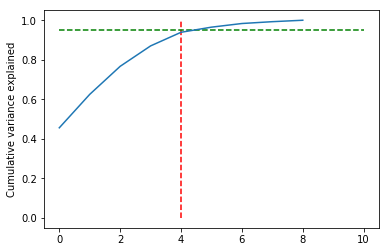

In [19]:
var_cumu = np.cumsum(pca.explained_variance_ratio_)
fig = plt.figure(figsize=[6,4])
plt.vlines(x=4, ymax=1, ymin=0, colors="r", linestyles="--")
plt.hlines(y=0.95, xmax=10, xmin=0, colors="g", linestyles="--")
plt.plot(var_cumu)
plt.ylabel("Cumulative variance explained")
plt.show()

##### We will take 5 variables which are nothing but Principal Components

In [20]:
pca_final = PCA(n_components=5, random_state=42)
df_countries_pca = pca_final.fit_transform(df_scaled[features])
df_countries_pca = pd.DataFrame(df_countries_pca)
df_countries_pca.shape

(161, 5)

In [21]:
df_countries_pca.head()

,0,1,2,3,4
0,-3.003575,-0.468144,-1.090041,0.594664,0.141524
1,0.501599,-0.099215,-0.044381,-1.398310,0.082154
2,-0.251082,-0.594533,1.668799,-0.433734,0.256338
3,-3.106675,0.859515,1.761971,1.980060,0.025583
4,1.188870,0.738069,-0.002597,-0.711522,-0.375459


In [22]:
corrmat = np.round(np.corrcoef(df_countries_pca.transpose()), 4)

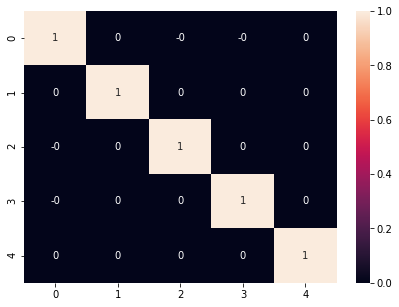

In [23]:
plt.figure(figsize=[7,5])
sns.heatmap(corrmat, annot=True)

#### As can be seen, now there is a very less correlation among the variables.

In [24]:
# As there is certain randomization used in the calculation of the Hopkins Score, let's take average of 100 scores
avg_hopkins_score = np.sum ([hopkins(df_countries_pca) for i in range (100)]) / 100

printmd ('The average Hopkins score is **%.2f%%**.' % (avg_hopkins_score * 100) )

The average Hopkins score is **74.42%**.

*Such a high score indicates that the data can indeed by clusterized.*

We can now start with the KMeans clustering. First let us try to come to a conclusion on how many clusters are required

In [25]:
## K-Mean Clustering
# Check 
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
sil = []
for k in range(2,10):
    kmeans = KMeans(n_clusters  = k).fit(df_countries_pca)
    sil.append([k,silhouette_score(df_countries_pca, kmeans.labels_)])

In order to come to a conclusion on how many clusters have to be created, let us draw the silhouette scores against the number of possible clusters 

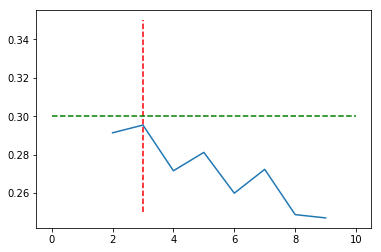

In [26]:
plt.plot(pd.DataFrame(sil)[0], pd.DataFrame(sil)[1])
plt.vlines(x=3, ymax=0.35, ymin=0.25, colors="r", linestyles="--")
plt.hlines(y=0.30, xmax=10, xmin=0, colors="g", linestyles="--")
plt.show()

### As seen in the above figure, the peak is coming with number of clusters = 3.
#### Let us draw the graph for the knee curve

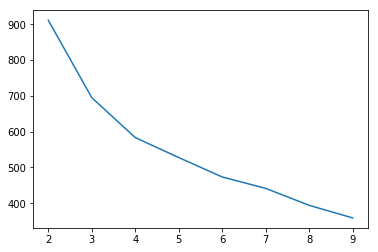

In [27]:
ssd = []
for k in range(2,10):
    k_mean = KMeans(n_clusters = k).fit(df_countries_pca)
    ssd.append([k, k_mean.inertia_])
    
plt.plot(pd.DataFrame(ssd)[0], pd.DataFrame(ssd)[1])

#### As seen in the above figure, the bend is happening at k=3

In [28]:
# Let's perfrom KMEAN=3
kmean5 = KMeans(n_clusters = 3, random_state=42)
kmean5.fit(df_countries_pca)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

In [29]:
df_countries_pca_clustered = pd.concat([df_countries_pca, \
                          pd.Series(1+kmean5.labels_).reset_index().drop('index', axis = 1)], \
                         axis=1)
df_countries_pca_clustered.columns = ['pca1', 'pca2', 'pca3', 'pca4', 'pca5', 'label']
df_countries_pca_clustered.head()

,pca1,pca2,pca3,pca4,pca5,label
0,-3.003575,-0.468144,-1.090041,0.594664,0.141524,3
1,0.501599,-0.099215,-0.044381,-1.398310,0.082154,2
2,-0.251082,-0.594533,1.668799,-0.433734,0.256338,2
3,-3.106675,0.859515,1.761971,1.980060,0.025583,3
4,1.188870,0.738069,-0.002597,-0.711522,-0.375459,2


### Visualizing the clusters as per the 5 Principal Components

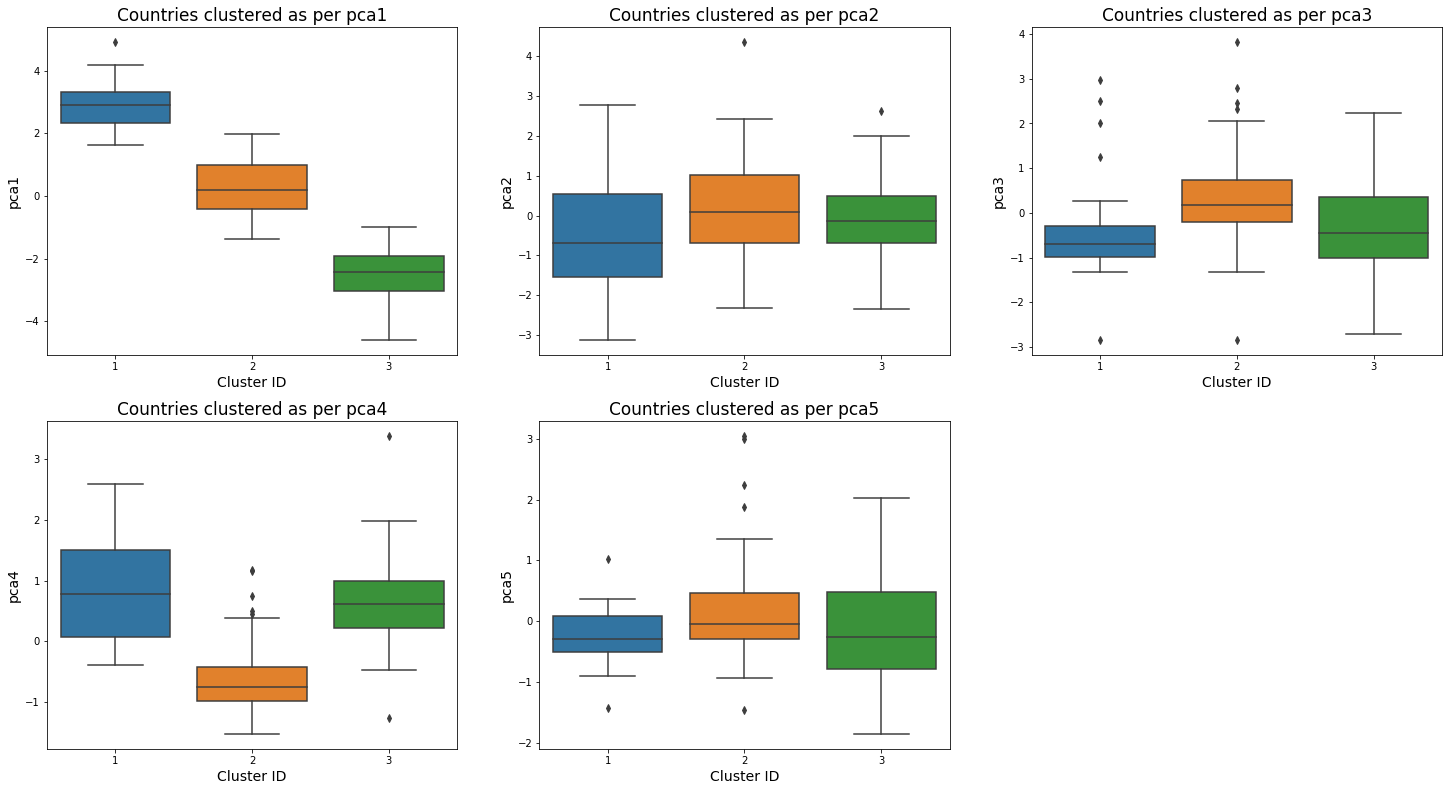

In [30]:
plt.figure(figsize = (25,35))
for i,f in enumerate(['pca1', 'pca2', 'pca3', 'pca4', 'pca5']):
    plt.subplot(5,3, i+1)
    sns.boxplot(x = 'label', y=f, data = df_countries_pca_clustered)
    plt.xlabel('Cluster ID', fontsize=14)
    plt.ylabel(f, fontsize=14)
    plt.title('Countries clustered as per ' + f, fontsize=17)
plt.show()

As can be seen, the 5 principal components are affecting the clusters
### Applying the cluster labels on the data frame which was formed after dropping of the outliers.

In [31]:
df_countries_capped.shape

(161, 10)

In [32]:
df_clustered = pd.concat([df_countries_capped, \
                          pd.Series(1+kmean5.labels_).reset_index().drop('index', axis = 1)], \
                         axis=1)
df_clustered.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,0
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553,3
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090,2
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460,2
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530,3
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200,2


In [33]:
df_clustered.columns = ['country', 'child_mort', 'exports', 'health', 'imports',
                        'income',  'inflation',  'life_expec', 'total_fer',
                        'gdpp', 'cluster_id']

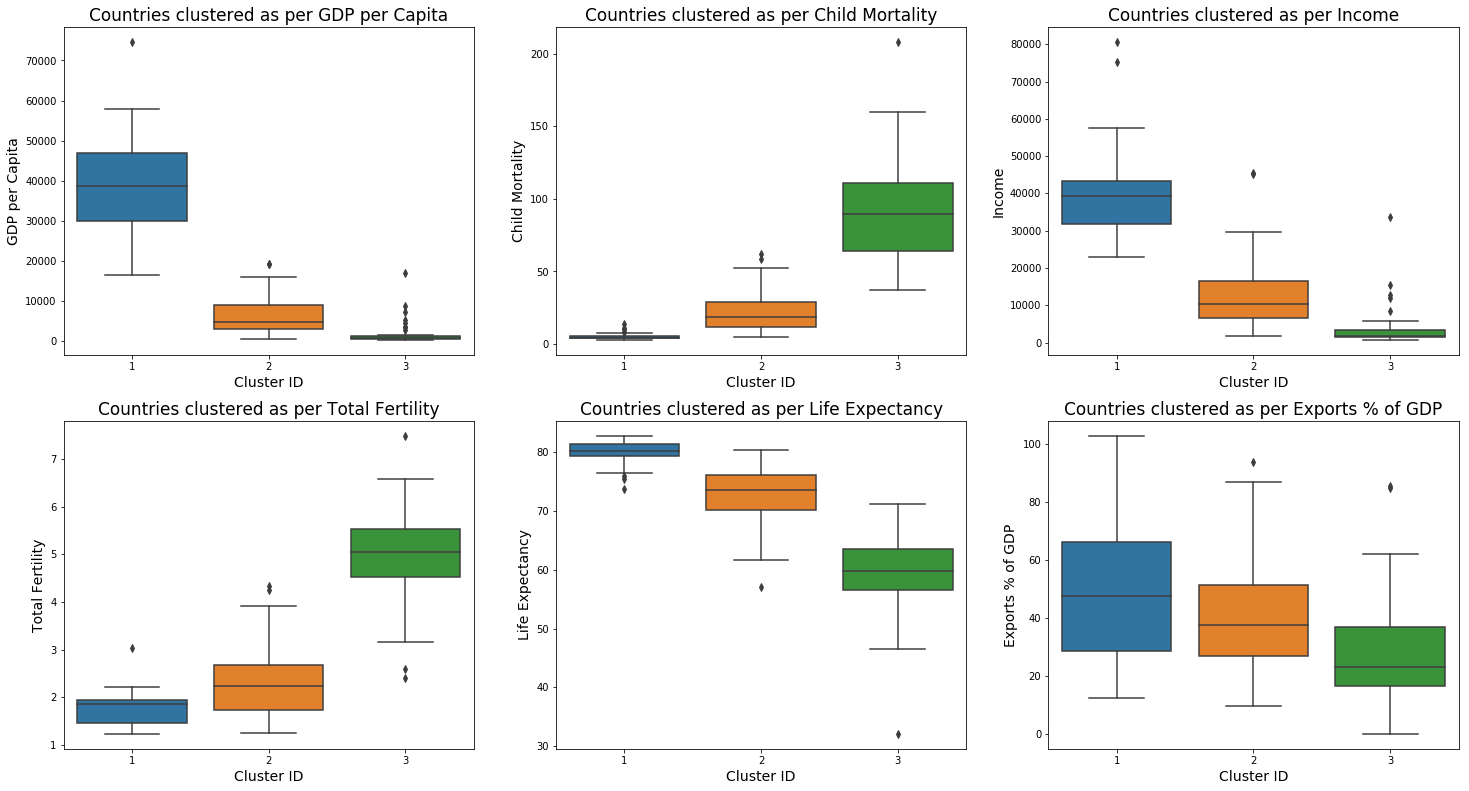

In [34]:
plt.figure(figsize = (25,35))
for i,f in enumerate(['gdpp', 'child_mort', 'income', 'total_fer', 'life_expec', 'exports']):
    plt.subplot(5,3, i+1)
    sns.boxplot(x = 'cluster_id', y=f, data = df_clustered)
    plt.xlabel('Cluster ID', fontsize=14)
    plt.ylabel(feature_map[f], fontsize=14)
    plt.title('Countries clustered as per ' + feature_map[f], fontsize=17)
plt.show()

It is clear that the cluster 3 is 
- *low* on exports, **gdpp**, **income** and **life expectancy**. 
- At the same time it is *very high* in terms of **child mortality rate**, **total fertility**.

Let us check on how is the child mortality related with the income and the gdpp using the scatter plots

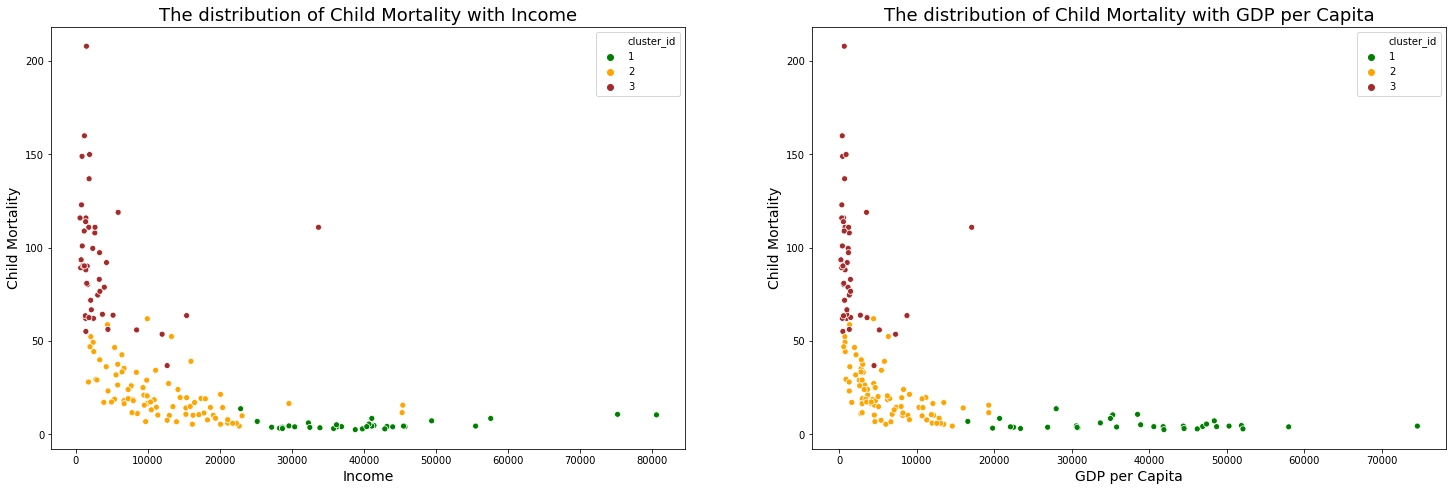

In [35]:
plt.figure(figsize = (25,45))
for i, f in enumerate(['income', 'gdpp']):
    plt.subplot(5,2, i+1)
    sns.scatterplot(x = f, y = 'child_mort', \
                data = df_clustered, hue= 'cluster_id', palette = ['green', 'orange', 'brown'])
    plt.xlabel(feature_map[f], fontsize=14)    
    plt.ylabel(feature_map['child_mort'], fontsize=14)
    plt.title('The distribution of %s with %s' % (feature_map['child_mort'], feature_map[f]), fontsize=18)
plt.show()

It is very evident that as the income and the gdpp goes down, the child mortality rate climbs up. Hence we should be helping out the cluster 3 countries.

In [36]:
printmd ('There are totally **%d** countries which are in the cluster 3, which requires utmost attention.' % \
         df_clustered.loc[df_clustered.cluster_id==3.0, 'country'].shape[0])

There are totally **46** countries which are in the cluster 3, which requires utmost attention.

In [37]:
printmd ('### These are the countries which need help:')
print ('; '.join(list(df_clustered.loc[df_clustered.cluster_id==3.0, 'country'].values)))

### These are the countries which need help:

Afghanistan; Angola; Benin; Burkina Faso; Burundi; Cameroon; Central African Republic; Chad; Comoros; Congo, Dem. Rep.; Congo, Rep.; Cote d'Ivoire; Equatorial Guinea; Eritrea; Gabon; Gambia; Ghana; Guinea; Guinea-Bissau; Haiti; Iraq; Kenya; Kiribati; Lao; Lesotho; Liberia; Madagascar; Malawi; Mali; Mauritania; Mozambique; Myanmar; Namibia; Niger; Pakistan; Rwanda; Senegal; Sierra Leone; South Africa; Sudan; Tanzania; Timor-Leste; Togo; Uganda; Yemen; Zambia


In [38]:
print ('These countries of the cluster 3 are worst in terms of child mortality and require urgent attention!\n\t'+\
       '\n\t'.join(list(df_clustered.loc[df_clustered.cluster_id==3.0, ['country', 'child_mort']].\
       sort_values(by='child_mort', ascending=False).head()['country'])))

These countries of the cluster 3 are worst in terms of child mortality and require urgent attention!
	Haiti
	Sierra Leone
	Chad
	Central African Republic
	Mali


******
## Let us check using the hierarchical clustering

In [39]:
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

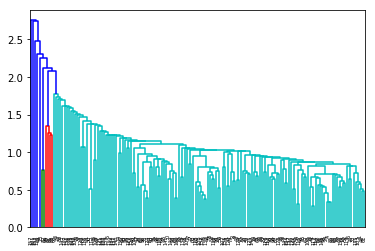

In [40]:
# Single linkage for better results
mergings = linkage(df_countries_pca, method="single", metric='euclidean')
dendrogram(mergings)
plt.show()

#### Single linkage does not look good. Let us try with the Complete linkage

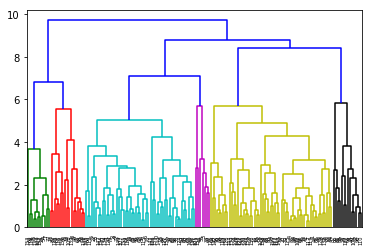

In [41]:
# Using complete linkage for better results
mergings = linkage(df_countries_pca, method="complete", metric='euclidean')
dendrogram(mergings)
plt.show()

In [42]:
# We will again try with 3 clusters
cluster_labels = cut_tree(mergings, n_clusters=3).reshape(-1, )

# Here we assign cluster labels
df_clustered_hierarch = df_countries_capped.copy()
df_clustered_hierarch['cluster_labels'] = cluster_labels
df_clustered_hierarch.shape

(161, 11)

### Let us see in the box plots, how are the clusters divided as per the GDPP, Child Mortality and Income

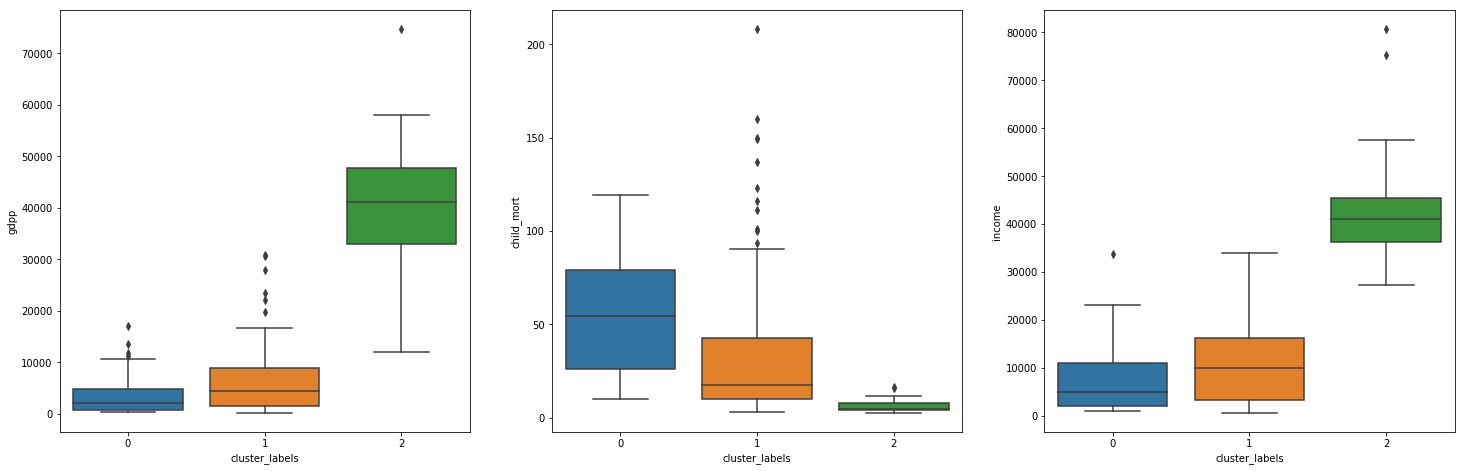

In [43]:
plt.figure(figsize = (25,45))
for i,f in enumerate(['gdpp', 'child_mort', 'income']):
    plt.subplot(5,3, i+1)
    sns.boxplot(x = 'cluster_labels', y=f, data = df_clustered_hierarch)

Here as well, we get a cluster 0, which has low gdpp and income. It is also on the higher side of the child mortality. The problem here seems to be that it has more 'range' compared to the cluster created by the k means. In fact, when it comes to the child mortality, it is ranging from almost 0 to almost 200+. This is a very big range. 

Let us check the scatter plots as well

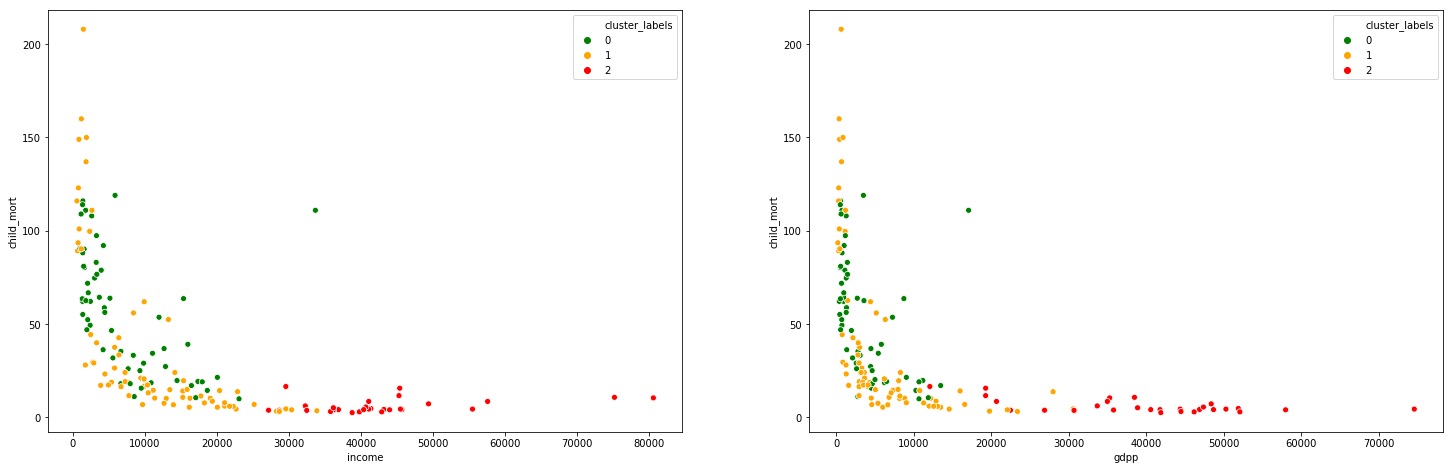

In [44]:
plt.figure(figsize = (25,45))
for i, f in enumerate(['income', 'gdpp']):
    plt.subplot(5,2, i+1)
    sns.scatterplot(x = f, y = 'child_mort', \
                data = df_clustered_hierarch, hue= 'cluster_labels', palette = ['green', 'orange', 'red'])
plt.show()

The clusters are all over the place. We cannot use these